<a href="https://colab.research.google.com/github/Riznap/capstone/blob/master/Battle_of_neihbourhood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Battle Of Neighbourhoods

## Importing Dependancies

In [0]:
import pandas as pd
import numpy as np

In [0]:
import requests

In [0]:
import folium

In [0]:
import math

In [0]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

In [0]:
from scipy.spatial.distance import cdist 

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")

In [0]:
delhi_geo=r'delhi.json'

In [0]:
delhi_map=folium.Map(location=[28.6304,77.2177], zoom_start=11)
folium.GeoJson(
    delhi_geo,
    name='geojson'
).add_to(delhi_map)
delhi_map

## Importing the Dataset

In [0]:
delhi_neighbourhood=pd.read_html('http://www.elections.in/delhi/mcd-elections/mcd-ward-list-2017.html')

In [0]:
delhi_neighbourhood=delhi_neighbourhood[0]
delhi_neighbourhood.head(10)

,AC No.,AC Name,Ward No.,Ward Name,Total Population,SC Population
0,East Delhi Municipal Corporation,East Delhi Municipal Corporation,East Delhi Municipal Corporation,East Delhi Municipal Corporation,East Delhi Municipal Corporation,East Delhi Municipal Corporation
1,55,TRILOKPURI,001-E,MAYUR VIHAR PHASE-I,61348,17546
2,NaN,NaN,002-E,TRILOKPURI-EAST,59678,33296
3,NaN,NaN,003-E,TRILOKPURI-WEST,64346,22075
4,NaN,NaN,004-E,NEW ASHOK NAGAR,56168,3689
5,56,KONDLI,005-E,KONDLI,62399,17502
6,NaN,NaN,006-E,GHAROLI,53891,12145
7,NaN,NaN,007-E,DALLUPURA,58056,4403
8,NaN,NaN,008-E,KALYAN PURI,59370,28644
9,57,PATPARGANJ,009-E,MANDAWALI,49753,6804


## Cleaning the Data

### Dropping unnecessary columns

In [0]:
delhi_neighbourhood.drop(['Ward Name','Ward No.','AC No.','SC Population'],inplace=True,axis=1)  

### Dropping unnecessary rows

In [0]:
delhi_neighbourhood.set_index('AC Name',inplace=True)
delhi_neighbourhood.drop(index=['East Delhi Municipal Corporation','North Delhi Municipal Corporation','South Delhi Municipal Corporation'],inplace=True)
delhi_neighbourhood.reset_index(level=0, inplace=True)

### Extracting the relevant informantion to a new dataframe

In [0]:
delhi_neighbourhood=delhi_neighbourhood.astype({'AC Name':'str','Total Population':int})
delhi_neighbourhood.head()

,AC Name,Total Population
0,TRILOKPURI,61348
1,nan,59678
2,nan,64346
3,nan,56168
4,KONDLI,62399


In [0]:
cols=['Neighbourhood','Population']
rows=range(delhi_neighbourhood['AC Name'].count()+1)
df=pd.DataFrame(columns=cols,index=rows)
df.head()

,Neighbourhood,Population
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


In [0]:
name=' '
pop=0
j=0
for i in range(len(delhi_neighbourhood)):
    if delhi_neighbourhood['AC Name'][i]!='nan':
        df['Neighbourhood'][j]=name
        df['Population'][j]=pop
        j=j+1
        name=delhi_neighbourhood['AC Name'][i]
        pop=delhi_neighbourhood['Total Population'][i]
    elif  delhi_neighbourhood['AC Name'][i]=='nan':
        pop=pop+delhi_neighbourhood['Total Population'][i]
df.shape

(273, 2)

In [0]:
df.drop(index=0,inplace=True)
df.dropna(how='any',inplace=True)
df.shape

(67, 2)

In [0]:
df.reset_index(level=0,inplace=True)

In [0]:
df.drop('index',axis=1,inplace=True)
df.head()


,Neighbourhood,Population
0,TRILOKPURI,241540
1,KONDLI,233716
2,PATPARGANJ,221317
3,LAXMI NAGAR,241422
4,VISHWAS NAGAR,222188


### Adding latitude and longitude data to the dataframe

In [0]:
df['latitude']=0.00
df['longitude']=0.00
df.head()

,Neighbourhood,Population,latitude,longitude
0,TRILOKPURI,241540,0.0,0.0
1,KONDLI,233716,0.0,0.0
2,PATPARGANJ,221317,0.0,0.0
3,LAXMI NAGAR,241422,0.0,0.0
4,VISHWAS NAGAR,222188,0.0,0.0


In [0]:
for i in range(len(df)):
    place=df['Neighbourhood'][i]+',delhi'
    if geolocator.geocode(place)!=None:
        location=geolocator.geocode(place)
        df['latitude'][i]=location.latitude
        df['longitude'][i]=location.longitude
    else: continue
 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
df[df['latitude']==0]

,Neighbourhood,Population,latitude,longitude
8,SEEMA PURI,235350,0.0,0.0
11,GHONDA,243379,0.0,0.0
14,MUSTAFABAD,311501,0.0,0.0
26,NANGLOI JAT,261081,0.0,0.0
27,MANGOL PURI,231907,0.0,0.0
30,SHAKUR BASTI,197655,0.0,0.0
41,RAJINDER NAGAR,202067,0.0,0.0


#### WE See that goolocater has no data on some neighbourhoods, hence we need to enter them manually

In [0]:
df['latitude'][8]= 28.690951
df['longitude'][8]=77.326968

df['latitude'][11]=28.69032
df['longitude'][11]=77.265659

df['latitude'][14]=28.711397
df['longitude'][14]=77.268109

df['latitude'][26]=28.678451
df['longitude'][26]=77.06724

df['latitude'][27]=28.692295
df['longitude'][27]=77.091639

df['latitude'][30]=28.681657
df['longitude'][30]=77.128082

df['latitude'][41]=28.637235
df['longitude'][41]=77.182364

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWi

### Plotiing the Neigbourhoods

In [0]:
df.head()

,Neighbourhood,Population,latitude,longitude
0,TRILOKPURI,241540,28.605647,77.306648
1,KONDLI,233716,28.607082,77.324332
2,PATPARGANJ,221317,28.611592,77.290564
3,LAXMI NAGAR,241422,28.630553,77.277575
4,VISHWAS NAGAR,222188,28.664470,77.291741


In [0]:

for lat,lon,label  in zip(df['latitude'],df['longitude'],df['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
          [lat, lon],
          radius=5,
          popup=label,
          color='blue',
          fill=True,
          fill_color='#3186cc',
          fill_opacity=0.7,
          parse_html=False).add_to(delhi_map)
delhi_map

In [0]:
delhi_df=df.copy()

### Calculating the nearest neigbours of each neighbourhood

In [0]:
lat_lon=delhi_df[['latitude','longitude']]
nbrs = NearestNeighbors(n_neighbors=2, algorithm='brute').fit(lat_lon)
distances, indices = nbrs.kneighbors(lat_lon)

In [0]:
n_neighbour=[indices[i][1] for i in range(len(indices))]

In [0]:

from math import radians, cos, sin, asin, sqrt

def dist(lat1,lng1,lat2,lng2):
    lat1,lng1,lat2,lng2 = map(radians, [lat1,lng1,lat2,lng2])

    # haversine formula 
    dlng = lng2 - lng1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlng/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c*r


In [0]:
delhi_df['radius']=0.00
for i in range(len(delhi_df)):
    lat1=delhi_df['latitude'][i]
    lng1=delhi_df['longitude'][i]
    lat2=delhi_df['latitude'][n_neighbour[i]]
    lng2=delhi_df['longitude'][n_neighbour[i]]
    delhi_df['radius'][i]=dist(lat1,lng1,lat2,lng2)/2*1000

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [0]:
for i in range(len(delhi_df)):
    if delhi_df['radius'][i]<750:
        delhi_df['radius'][i]=750
    else: continue
delhi_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Neighbourhood,Population,latitude,longitude,radius
0,TRILOKPURI,241540,28.605647,77.306648,851.789984
1,KONDLI,233716,28.607082,77.324332,866.829819
2,PATPARGANJ,221317,28.611592,77.290564,851.789984
3,LAXMI NAGAR,241422,28.630553,77.277575,1230.077742
4,VISHWAS NAGAR,222188,28.664470,77.291741,750.000000


# Taking the input rom user about the cuisine of the restaurant

In [0]:
cuisine=input('Enter the cuisine ')

Enter the cuisine indian


In [0]:
#@title Adding Foursquare Credentials {display-mode: "form"}


CLIENT_ID = 'LW20LDSOAKWXJ0FDQI3DGAGHYNU2ZX3WRYSZLPJUU2FQPXB4'
CLIENT_SECRET = 'ABFK15TR4QQU1HA044ZV3DEYWXZMUDIXRGWQZTQIPQ2X4FHT'
VERSION = '20180605'


In [0]:
del_venues=delhi_df.copy()

In [0]:
del_venues['cuisine']=0 # no of restaurants of same cuisine in the neigbourhood
del_venues['restaurant']=0 #no of restaurant in general
del_venues['venues']=0 #no of total venues in the area

In [0]:
del_venues.head()

,Neighbourhood,Population,latitude,longitude,radius,cuisine,restaurant,venues
0,TRILOKPURI,241540,28.605647,77.306648,851.789984,0,0,0
1,KONDLI,233716,28.607082,77.324332,866.829819,0,0,0
2,PATPARGANJ,221317,28.611592,77.290564,851.789984,0,0,0
3,LAXMI NAGAR,241422,28.630553,77.277575,1230.077742,0,0,0
4,VISHWAS NAGAR,222188,28.664470,77.291741,750.000000,0,0,0


In [0]:
for i in range(len(del_venues)):
    lat=delhi_df['latitude'][i]
    lng=delhi_df['longitude'][i]
    radius=delhi_df['radius'][i]
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&intent=checkin'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng,
        radius,
        200)
    results = requests.get(url).json()
    venues=results['response']['venues']
    restaurant=0
    num=0
    for j in range(len(venues)):
        if len(venues[j]['categories'])>0:
            category = venues[j]['categories'][0]['name']
            if 'restaurant' in category.lower():
                restaurant=restaurant+1
                if cuisine in category.lower():
                    num=num+1
                else:continue
            else: continue
        else: continue
    del_venues['cuisine'][i]=num
    del_venues['restaurant'][i]=restaurant
    del_venues['venues'][i]=len(venues)-restaurant
        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [0]:
del_venues.head()

,Neighbourhood,Population,latitude,longitude,radius,cuisine,restaurant,venues,labels
0,TRILOKPURI,241540,28.605647,77.306648,851.789984,13,18,163,0
1,KONDLI,233716,28.607082,77.324332,866.829819,4,4,144,1
2,PATPARGANJ,221317,28.611592,77.290564,851.789984,4,7,82,1
3,LAXMI NAGAR,241422,28.630553,77.277575,1230.077742,11,17,108,0
4,VISHWAS NAGAR,222188,28.664470,77.291741,750.000000,5,13,105,1


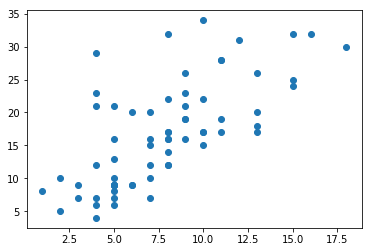

In [0]:
x=del_venues['cuisine']
y=del_venues['restaurant']
plt.scatter(x, y)

In [0]:
data=del_venues[['cuisine','restaurant']]
inertias=[]
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k,init='k-means++').fit(data) 
    inertias.append(kmeanModel.inertia_)

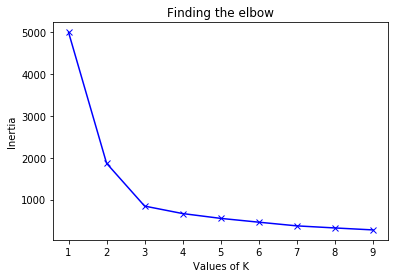

In [0]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('Finding the elbow') 
plt.show()

Clearly the elbow is at k=3


In [0]:
kmeans=KMeans(n_clusters=3,init='k-means++').fit(data) 

In [0]:
del_venues['labels']=kmeans.labels_

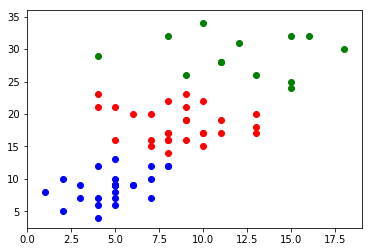

In [0]:
colors=['red','blue','green']
for i in range(len(del_venues)):
    plt.scatter(del_venues['cuisine'][i],del_venues['restaurant'][i],color=colors[kmeans.labels_[i]])

In [0]:
dis_c=cdist([[0,0]],kmeans.cluster_centers_,'euclidean').tolist()
req_cluster=dis_c[0].index(min(dis_c[0]))

In [0]:
places=del_venues[del_venues['labels']==req_cluster][['Neighbourhood','Population','venues']]
records=places.values.tolist()

In [0]:
records.sort(key = lambda l: (l[2]))

In [0]:
print('Therefore the best places to start a '+str(cuisine)+' restaurant are:\n')
for i in range(5):
    print(str(records[-1-i][0])+"\n")

Therefore the best places to start a indian restaurant are:

BAWANA

KONDLI

ROHTAS NAGAR

MANGOL PURI

SULTANPUR MAJRA

